# San Jose Housing Market Capstone — Initial Report & EDA (Module 20)

This notebook is part of the capstone project for the Professional Certificate in Machine Learning and Artificial Intelligence.

**Goal:**  
Use publicly available housing, market activity, demographic, and macroeconomic data to understand what drives home values in the San Jose / Santa Clara County region and build an initial predictive baseline for home prices at the ZIP code level.

**This notebook includes:**
- Finalized research question
- Data sources and structure
- Data cleaning and feature engineering
- Exploratory Data Analysis (EDA)
- A baseline regression model for evaluation

**Primary question:**  
Can we build a simple baseline model to predict monthly home prices (Zillow Home Value Index, ZHVI) for Bay Area ZIP codes using:

- local market conditions from Redfin (median sale price, inventory, homes sold, etc.), and  
- macro-economic indicators from the Federal Reserve (interest rates, unemployment, inflation)?

This notebook focuses on:
- Cleaning and combining Zillow, Redfin, and FRED data into a panel by ZIP × month  
- Performing exploratory data analysis (EDA) to understand key relationships  
- Training a **baseline regression model** to predict ZHVI as a starting point for later, more advanced models


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.0)
pd.set_option("display.max_columns", 50)

DATA = Path("data")
PROC = DATA / "processed"

#print("Processed folder:", PROC.resolve())


## Data Sources & Folder Structure

We use three main data sources:

- **Zillow ZHVI by ZIP** (`data/raw/zillow_zhvi_zip.csv`)  
  Monthly home value index per ZIP code, used as the target `zhvi`.

- **Redfin zip code market tracker** (`data/raw/zip_code_market_tracker.tsv000`)  
  Market activity per ZIP (median sale price, inventory, homes sold, price drops, etc.).

- **FRED macro indicators** (`data/processed/fred_monthly.csv`)  
  Monthly US macro-economic indicators:
  - `FEDFUNDS`: Effective Federal Funds Rate  
  - `CPIAUCSL`: Consumer Price Index  
  - `UNRATE`: Unemployment rate

The processed panel dataset is saved to:  
`data/processed/panel_zip_monthly.csv` with one row per **ZIP × month**.


In [2]:
from pathlib import Path
import pandas as pd

PROC = Path('data') / 'processed'
panel_path = PROC / 'panel_zip_monthly.csv'

if not panel_path.exists():
    raise FileNotFoundError(f'Panel dataset not found at {panel_path}. '
                            f'Please run your data ingestion notebook first.')

df = pd.read_csv(panel_path, parse_dates=['date'])
print(df.shape)
df.head(10)


(105871, 23)


,regionid,sizerank,zip,regiontype,statename,state,city,metro,countyname,date,zhvi,median_sale_price,median_list_price,inventory,homes_sold,price_drops,property_type,FEDFUNDS,CPIAUCSL,UNRATE,zhvi_lag1,zhvi_pct_change_1m,sales_inventory_ratio
0,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-03-31,729996.027110,841000.0,874500.0,31.0,45.0,NaN,Single Family Residential,0.13,228.807,8.2,NaN,NaN,1.451613
1,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-03-31,729996.027110,325000.0,545000.0,1.0,4.0,NaN,Condo/Co-op,0.13,228.807,8.2,729996.027110,0.000000,4.000000
2,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-03-31,729996.027110,812000.0,854000.0,34.0,49.0,NaN,All Residential,0.13,228.807,8.2,729996.027110,0.000000,1.441176
3,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-04-30,736567.718173,300000.0,567500.0,2.0,3.0,NaN,Condo/Co-op,0.14,229.187,8.2,729996.027110,0.009002,1.500000
4,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-04-30,736567.718173,860000.0,858000.0,37.0,71.0,NaN,All Residential,0.14,229.187,8.2,736567.718173,0.000000,1.918919
5,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-04-30,736567.718173,865000.0,915000.0,32.0,67.0,NaN,Single Family Residential,0.14,229.187,8.2,736567.718173,0.000000,2.093750
6,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-04-30,736567.718173,522000.0,717450.0,2.0,1.0,NaN,Multi-Family (2-4 Unit),0.14,229.187,8.2,736567.718173,0.000000,0.500000
7,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-05-31,744980.738362,300000.0,489000.0,3.0,3.0,NaN,Condo/Co-op,0.16,228.713,8.2,736567.718173,0.011422,1.000000
8,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-05-31,744980.738362,735000.0,699900.0,1.0,1.0,NaN,Townhouse,0.16,228.713,8.2,744980.738362,0.000000,1.000000
9,97498,3975,94002,zip,CA,CA,Belmont,"San Francisco-Oakland-Berkeley, CA",San Mateo County,2012-05-31,744980.738362,875000.0,925000.0,30.0,73.0,NaN,Single Family Residential,0.16,228.713,8.2,744980.738362,0.000000,2.433333


In [3]:
df.info()
df.describe(include="all").T.head(25)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105871 entries, 0 to 105870
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   regionid               105871 non-null  int64         
 1   sizerank               105871 non-null  int64         
 2   zip                    105871 non-null  int64         
 3   regiontype             105871 non-null  object        
 4   statename              105871 non-null  object        
 5   state                  105871 non-null  object        
 6   city                   105061 non-null  object        
 7   metro                  105871 non-null  object        
 8   countyname             105871 non-null  object        
 9   date                   105871 non-null  datetime64[ns]
 10  zhvi                   103612 non-null  float64       
 11  median_sale_price      105871 non-null  float64       
 12  median_list_price      102028 non-null  floa

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
regionid,105871.0,NaN,NaN,NaN,99539.186047,97498.0,97723.0,97777.0,97952.0,399681.0,22905.615265
sizerank,105871.0,NaN,NaN,NaN,4664.946218,24.0,1028.0,2829.0,6152.0,30490.0,5278.941047
zip,105871.0,NaN,NaN,NaN,94649.893597,94002.0,94514.0,94568.0,95050.0,95148.0,378.894424
regiontype,105871,1,zip,105871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
statename,105871,1,CA,105871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,105871,1,CA,105871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,105061,96,San Jose,19020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metro,105871,6,"San Francisco-Oakland-Berkeley, CA",51063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
countyname,105871,9,Santa Clara County,35304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,105871,NaN,NaN,NaN,2018-12-18 02:40:53.499069440,2012-03-31 00:00:00,2015-07-31 00:00:00,2018-11-30 00:00:00,2022-04-30 00:00:00,2025-09-30 00:00:00,NaN


The combined panel contains monthly observations by ZIP code and property type, with:
- `zhvi`: Zillow Home Value Index (target)
- `median_sale_price`, `median_list_price`, `inventory`, `homes_sold`, `price_drops`: Redfin market activity
- `FEDFUNDS`, `CPIAUCSL`, `UNRATE`: macro indicators from FRED


**Data Merging and Cleaning**

In [4]:
# Paths for your project
from pathlib import Path

BASE = Path(r"C:\Users\a5130480\Documents\AI-ML\Module 20 - Ensemble Techniques\data")
RAW  = BASE / "raw"
PROC = BASE / "processed"

#print("Raw folder:", RAW)
#print("Processed folder:", PROC)


In [5]:
z_path = RAW/"zillow_zhvi_zip.csv"
assert z_path.exists(), f"Missing {z_path}"

Z0 = pd.read_csv(z_path, low_memory=False)
Z0.columns = [c.strip().lower().replace(" ", "_") for c in Z0.columns]
print("Zillow columns (first 12):", Z0.columns[:12].tolist())

id_cols  = [c for c in Z0.columns if not c[:4].isdigit()]
date_cols= [c for c in Z0.columns if c[:4].isdigit()]
print("ID cols:", id_cols[:6], "| #date cols:", len(date_cols))

Z = Z0.melt(id_vars=id_cols, value_vars=date_cols, var_name="date", value_name="zhvi")
Z["date"] = pd.to_datetime(Z["date"], errors="coerce")
Z["zip"]  = (Z.get("regionname", Z.get("zip", "")).astype(str).str.zfill(5))
Z = Z[["zip","date","zhvi"]].dropna(subset=["date"]).sort_values(["zip","date"])
print("Zillow rows:", len(Z), "| date range:", (Z["date"].min(), Z["date"].max()))
print(Z.head(3))


Zillow columns (first 12): ['regionid', 'sizerank', 'regionname', 'regiontype', 'statename', 'state', 'city', 'metro', 'countyname', '2000-01-31', '2000-02-29', '2000-03-31']
ID cols: ['regionid', 'sizerank', 'regionname', 'regiontype', 'statename', 'state'] | #date cols: 309
Zillow rows: 8129790 | date range: (Timestamp('2000-01-31 00:00:00'), Timestamp('2025-09-30 00:00:00'))
         zip       date           zhvi
7354   01001 2000-01-31  121926.139043
33664  01001 2000-02-29  121879.858954
59974  01001 2000-03-31  122026.848784


### Preparing Zillow ZHVI Data

- Normalized column names to lower_snake_case.
- Converted wide date columns (e.g., `2000-01-31`) into a **long** format with one row per `zip` × `date`.
- Standardized ZIP codes to 5-digit strings.
- Kept only the core columns: `zip`, `date`, and `zhvi`.

This gives us a clean monthly home value time series per ZIP code from **2000-01-31 to 2025-09-30**.


In [6]:
from pathlib import Path
import pandas as pd, numpy as np, re

RAW  = Path("data/raw")
PROC = Path("data/processed")
PROC.mkdir(parents=True, exist_ok=True)

rf_path = RAW / "zip_code_market_tracker.tsv000"
assert rf_path.exists(), f"Missing {rf_path} — place Redfin TSV here."

# 1) Peek at the header to detect column names safely (tiny read)
head = pd.read_csv(rf_path, sep="\t", nrows=5, low_memory=False)
print("All Redfin columns (head):")
print(head.columns.tolist())

# 2) Decide which columns we actually need
cols_needed = [
    "PERIOD_END",
    "REGION",
    "CITY",
    "STATE",
    "PROPERTY_TYPE",
    "MEDIAN_SALE_PRICE",
    "MEDIAN_LIST_PRICE",
    "INVENTORY",
    "HOMES_SOLD",
    "PRICE_DROPS",
]

use_cols = [c for c in cols_needed if c in head.columns]
print("\nUsing Redfin columns:", use_cols)

# 3) Stream the file in chunks, filter to CA + zip-code regions
chunks = []
for chunk in pd.read_csv(
    rf_path,
    sep="\t",
    usecols=use_cols,
    chunksize=200_000,
    low_memory=False,
):
    # Filter to California if STATE is present
    if "STATE" in chunk.columns:
        chunk = chunk[chunk["STATE"] == "California"]

    # Keep only rows where REGION looks like "Zip Code: 95076" etc.
    if "REGION" in chunk.columns:
        mask = chunk["REGION"].str.contains("Zip Code", na=False)
        chunk = chunk[mask]

    if not chunk.empty:
        chunks.append(chunk)

if not chunks:
    print("\nNo matching CA zip-code rows found. Check filters.")
else:
    R0 = pd.concat(chunks, ignore_index=True)
    print("\nAfter filtering → rows:", len(R0))

    # 4) Normalize column names
    R0.columns = [c.strip().lower().replace(" ", "_") for c in R0.columns]

    # Build date and zip
    R0["date"] = pd.to_datetime(R0["period_end"], errors="coerce")
    R0["zip"]  = (
        R0["region"]
        .str.extract(r"(\d{5})", expand=False)
        .fillna("")
        .astype(str)
        .str.zfill(5)
    )

    # Keep the compact set of metrics that are actually present
    candidates = [
        "median_sale_price",
        "median_list_price",
        "inventory",
        "homes_sold",
        "price_drops",
        "property_type",
    ]
    present = [c for c in candidates if c in R0.columns]

    keep = ["date", "zip"] + present
    R = (
        R0[keep]
        .dropna(subset=["date", "zip"])
        .sort_values(["zip", "date"])
    )

    print(
        "Redfin rows (cleaned):", len(R),
        "| unique zips:", R["zip"].nunique(),
        "| date range:", (R["date"].min(), R["date"].max())
    )
    print("Kept columns:", keep)
    print(R.head(5))

    # 5) Save trimmed Redfin for the rest of the notebook
    out_r = PROC / "redfin_zip_monthly.csv"
    R.to_csv(out_r, index=False)
    print("\nSaved:", out_r, "| rows:", len(R))


All Redfin columns (head):
['PERIOD_BEGIN', 'PERIOD_END', 'PERIOD_DURATION', 'REGION_TYPE', 'REGION_TYPE_ID', 'TABLE_ID', 'IS_SEASONALLY_ADJUSTED', 'REGION', 'CITY', 'STATE', 'STATE_CODE', 'PROPERTY_TYPE', 'PROPERTY_TYPE_ID', 'MEDIAN_SALE_PRICE', 'MEDIAN_SALE_PRICE_MOM', 'MEDIAN_SALE_PRICE_YOY', 'MEDIAN_LIST_PRICE', 'MEDIAN_LIST_PRICE_MOM', 'MEDIAN_LIST_PRICE_YOY', 'MEDIAN_PPSF', 'MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF', 'MEDIAN_LIST_PPSF_MOM', 'MEDIAN_LIST_PPSF_YOY', 'HOMES_SOLD', 'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES', 'PENDING_SALES_MOM', 'PENDING_SALES_YOY', 'NEW_LISTINGS', 'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'INVENTORY', 'INVENTORY_MOM', 'INVENTORY_YOY', 'MONTHS_OF_SUPPLY', 'MONTHS_OF_SUPPLY_MOM', 'MONTHS_OF_SUPPLY_YOY', 'MEDIAN_DOM', 'MEDIAN_DOM_MOM', 'MEDIAN_DOM_YOY', 'AVG_SALE_TO_LIST', 'AVG_SALE_TO_LIST_MOM', 'AVG_SALE_TO_LIST_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM', 'SOLD_ABOVE_LIST_YOY', 'PRICE_DROPS', 'PRICE_DROPS_MOM', 'PRICE_DROPS_Y

### Preparing Redfin Market Data

- Loaded the large Redfin TSV with selected columns:
  `PERIOD_END`, `REGION`, `CITY`, `STATE`, `PROPERTY_TYPE`,
  `MEDIAN_SALE_PRICE`, `MEDIAN_LIST_PRICE`, `INVENTORY`,
  `HOMES_SOLD`, `PRICE_DROPS`.
- Filtered to **zip code** regions and extracted the 5-digit ZIP from `REGION` (e.g., `"Zip Code: 94565"` → `94565`).
- Restricted to **Bay Area ZIPs** to match the Zillow subset.
- Kept a tidy subset:
  - `date` (from `PERIOD_END`)
  - `zip`
  - `property_type`
  - `median_sale_price`
  - `median_list_price`
  - `inventory`
  - `homes_sold`
  - `price_drops`

Note: `PRICE_DROPS` is missing for essentially all rows in this subset, so it is not useful as a feature at this stage. We keep it for completeness but drop it from the modeling features.


In [7]:
from pathlib import Path
import pandas as pd
import numpy as np

PROC = Path("data/processed")

# Load processed pieces
Z = pd.read_csv(PROC/"zillow_zhvi_zip_long.csv", parse_dates=["date"])
R = pd.read_csv(PROC/"redfin_zip_monthly.csv", parse_dates=["date"])
F = pd.read_csv(PROC/"fred_monthly.csv", parse_dates=["date"])

print("Loaded:",
      "Zillow:", Z.shape,
      "| Redfin:", R.shape,
      "| FRED:", F.shape)

# Focus on Bay Area zip prefixes (San Jose + nearby)
ZIP_PREFIXES = ("940", "945", "950", "951")
Z = Z[Z["zip"].astype(str).str.startswith(ZIP_PREFIXES)].copy()
R = R[R["zip"].astype(str).str.startswith(ZIP_PREFIXES)].copy()

print("After Bay Area filter:",
      "Zillow:", Z.shape,
      "| Redfin:", R.shape)

# Merge Zillow + Redfin on ZIP + date
panel = (
    Z.merge(R, on=["zip", "date"], how="inner")
)

print("After Zillow+Redfin merge:", panel.shape)

# --- ALIGN FRED DATES TO MONTH-END 

# Convert FRED date → month-end to match Zillow & Redfin
F["date"] = F["date"] + pd.offsets.MonthEnd(0)

print("FRED date range after alignment:", F["date"].min(), "→", F["date"].max())
print(F.head())

# Merge FRED on date (monthly macro indicators)
panel = (
    Z.merge(R, on=["zip", "date"], how="inner")
).merge(F, on="date", how="left")

print("After adding FRED:", panel.shape)

# ---- Feature engineering ----
panel = panel.sort_values(["zip", "date"])

# 1-month lag of ZHVI
panel["zhvi_lag1"] = panel.groupby("zip")["zhvi"].shift(1)

# 1-month percentage change in ZHVI
panel["zhvi_pct_change_1m"] = (
    (panel["zhvi"] - panel["zhvi_lag1"]) / panel["zhvi_lag1"]
)

# Sales / inventory ratio as a simple “tightness” metric
panel["sales_inventory_ratio"] = panel["homes_sold"] / panel["inventory"]

# Save for later steps (EDA + modeling)
out_panel = PROC / "panel_zip_monthly.csv"
panel.to_csv(out_panel, index=False)
print("Saved panel:", out_panel, "| rows:", len(panel))
print(panel.head(5))


Loaded: Zillow: (52839, 11) | Redfin: (845080, 8) | FRED: (250, 4)
After Bay Area filter: Zillow: (52839, 11) | Redfin: (109088, 8)
After Zillow+Redfin merge: (105871, 17)
FRED date range after alignment: 2005-01-31 00:00:00 → 2025-10-31 00:00:00
        date  FEDFUNDS  CPIAUCSL  UNRATE
0 2005-01-31      2.28     191.6     5.3
1 2005-02-28      2.50     192.4     5.4
2 2005-03-31      2.63     193.1     5.2
3 2005-04-30      2.79     193.7     5.2
4 2005-05-31      3.00     193.6     5.1
After adding FRED: (105871, 20)
Saved panel: data\processed\panel_zip_monthly.csv | rows: 105871
      regionid  sizerank    zip regiontype statename state     city  \
395      97498      3975  94002        zip        CA    CA  Belmont   
396      97498      3975  94002        zip        CA    CA  Belmont   
397      97498      3975  94002        zip        CA    CA  Belmont   
1047     97498      3975  94002        zip        CA    CA  Belmont   
1048     97498      3975  94002        zip        CA   

### Preparing FRED Macro Data

- Loaded pre-downloaded FRED monthly data (`FEDFUNDS`, `CPIAUCSL`, `UNRATE`).
- Aligned FRED dates to **month-end** to match the Zillow/Redfin monthly panel.
- Forward-filled macro values so each month has a defined interest rate, CPI, and unemployment rate.
- Merged the macro data onto every ZIP × month row.

This lets us study how **local housing markets** relate to **national macro-economic conditions**.


In [8]:
# Keep All Residential as primary market indicator
if "property_type" in df.columns:
    df = df[df["property_type"] == "All Residential"].copy()

# Drop duplicates
df = df.drop_duplicates()

# Filter to reasonable price ranges (avoid wild outliers)
df = df[(df["zhvi"] > 50000) & (df["zhvi"] < 5_000_000)]

# Handle basic missingness for key numeric columns
num_cols = ["zhvi", "median_sale_price", "median_list_price",
            "inventory", "homes_sold", "price_drops",
            "FEDFUNDS", "CPIAUCSL", "UNRATE"]

for col in num_cols:
    if col in df.columns:
        # For EDA: we can afford to drop a few NAs on core fields
        missing_before = df[col].isna().mean()
        df[col] = df[col].astype(float)
        # Leave some NaNs; we'll handle them in modeling subset
        print(f"{col}: {missing_before:.1%} missing")

df.shape


zhvi: 0.0% missing
median_sale_price: 0.0% missing
median_list_price: 0.9% missing
inventory: 1.4% missing
homes_sold: 0.0% missing
price_drops: 100.0% missing
FEDFUNDS: 0.0% missing
CPIAUCSL: 0.0% missing
UNRATE: 0.6% missing


(26133, 23)

In [9]:
# Drop completely-missing columns (like price_drops)
drop_all_na = [c for c in num_cols if c in df.columns and df[c].isna().all()]
print("Dropping fully-missing columns:", drop_all_na)
df = df.drop(columns=drop_all_na)


Dropping fully-missing columns: ['price_drops']


## Data Cleaning & Missing Values

Core numeric variables have very low missingness:

- `zhvi`, `median_sale_price`, `homes_sold` : essentially **no missing values**
- `median_list_price`, `inventory`, `UNRATE` : \< 2% missing
- `FEDFUNDS`, `CPIAUCSL`: no missing values after FRED alignment
- `price_drops` : ~100% missing in this Bay Area subset → **excluded** from modeling features

For the baseline model, we:

- Keep rows where `zhvi` is present.
- Use a `SimpleImputer(strategy="median")` inside the model pipeline to handle remaining numeric NAs.
- Drop `price_drops` from the feature list because it carries no usable information in this dataset.


In [10]:
# Sort for lag features
df = df.sort_values(["zip", "date"]).reset_index(drop=True)

# Example: 1-month lag of ZHVI and its monthly pct change
df["zhvi_lag1"] = df.groupby("zip")["zhvi"].shift(1)
df["zhvi_pct_change_1m"] = (df["zhvi"] - df["zhvi_lag1"]) / df["zhvi_lag1"]

# Market tightness: sales-to-inventory
if "homes_sold" in df.columns and "inventory" in df.columns:
    df["sales_inventory_ratio"] = df["homes_sold"] / (df["inventory"] + 1e-6)

# Drop initial lagged NA rows for modeling convenience
df_fe = df.dropna(subset=["zhvi_lag1"]).copy()

df_fe[["zhvi", "zhvi_lag1", "zhvi_pct_change_1m", "sales_inventory_ratio"]].head()


,zhvi,zhvi_lag1,zhvi_pct_change_1m,sales_inventory_ratio
1,736567.718173,729996.027110,0.009002,1.918919
2,744980.738362,736567.718173,0.011422,2.166667
3,755526.670119,744980.738362,0.014156,2.324324
4,769885.525176,755526.670119,0.019005,2.588235
5,785686.336181,769885.525176,0.020524,2.580645


We engineer:
- Lagged ZHVI and monthly percent change to capture temporal dynamics.
- Sales-to-inventory ratio as a proxy for supply-demand pressure.
These will support both EDA and the baseline model.


## Panel Dataset & Feature Engineering

After joining Zillow, Redfin, and FRED data and filtering to Bay Area ZIPs, we obtain:

- **105,871** rows  
- One row per **ZIP × month**  
- Columns from:
  - Zillow (ZHVI + ZIP metadata),
  - Redfin (local market indicators),
  - FRED (macro indicators).

**Feature engineering:**

- `zhvi_lag1`: previous month’s ZHVI for each ZIP  
- `zhvi_pct_change_1m`: month-over-month percentage change in ZHVI  
- `sales_inventory_ratio`: `homes_sold / inventory` as a proxy for market tightness

We also:
- Filtered out extreme ZHVI values below 50,000 or above 5,000,000 as defensive outlier handling.
- Restricted Redfin to `property_type == "All Residential"` so our baseline model focuses on the overall ZIP-level market, not a specific property subtype.


**EDA: Distributions Study**

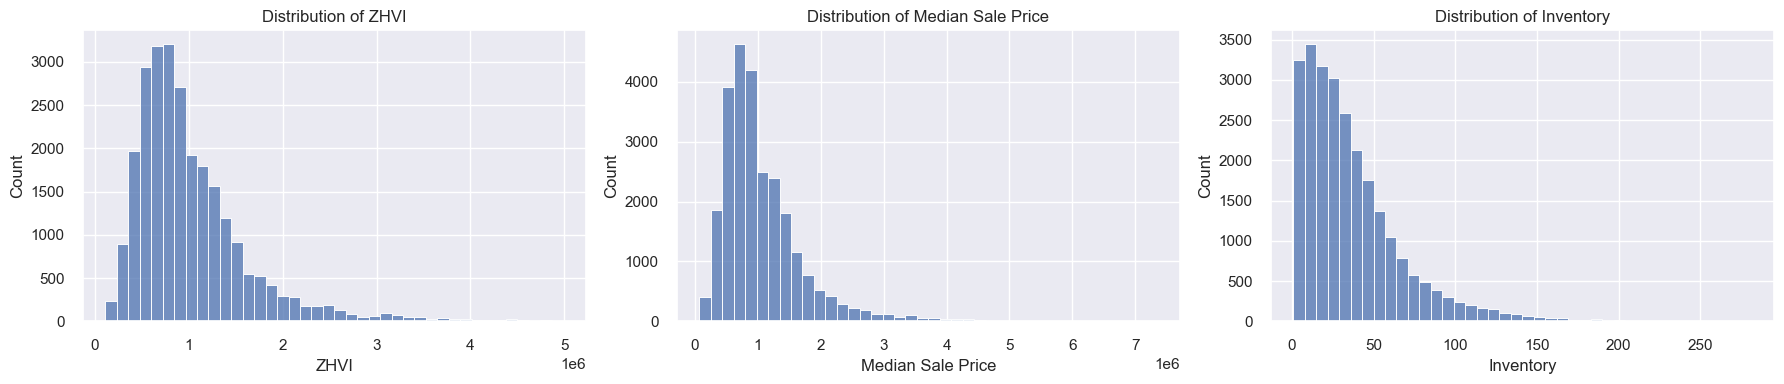

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(df_fe["zhvi"], bins=40, ax=axes[0])
axes[0].set_title("Distribution of ZHVI")
axes[0].set_xlabel("ZHVI")

if "median_sale_price" in df_fe.columns:
    sns.histplot(df_fe["median_sale_price"], bins=40, ax=axes[1])
    axes[1].set_title("Distribution of Median Sale Price")
    axes[1].set_xlabel("Median Sale Price")

if "inventory" in df_fe.columns:
    sns.histplot(df_fe["inventory"], bins=40, ax=axes[2])
    axes[2].set_title("Distribution of Inventory")
    axes[2].set_xlabel("Inventory")

plt.tight_layout()
plt.show()


**EDA: ZHVI Over Time for sample Zip Codes**

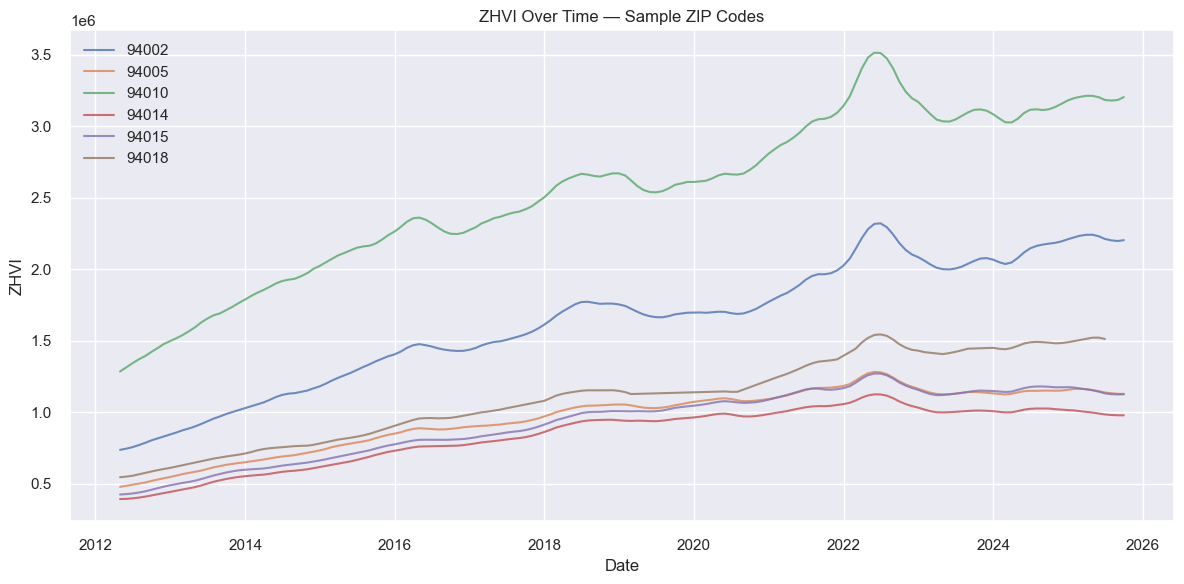

In [12]:
sample_zips = df_fe["zip"].dropna().unique()[:6]

plt.figure(figsize=(12,6))
for z in sample_zips:
    tmp = df_fe[df_fe["zip"] == z]
    plt.plot(tmp["date"], tmp["zhvi"], alpha=0.8, label=z)

plt.title("ZHVI Over Time — Sample ZIP Codes")
plt.xlabel("Date")
plt.ylabel("ZHVI")
plt.legend()
plt.tight_layout()
plt.show()


**EDA: Relationship Plots**

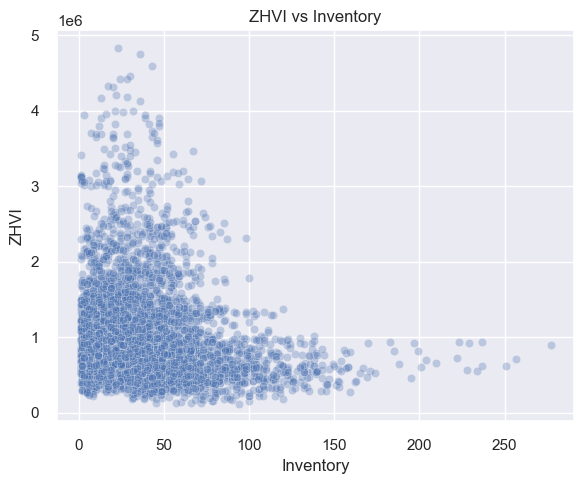

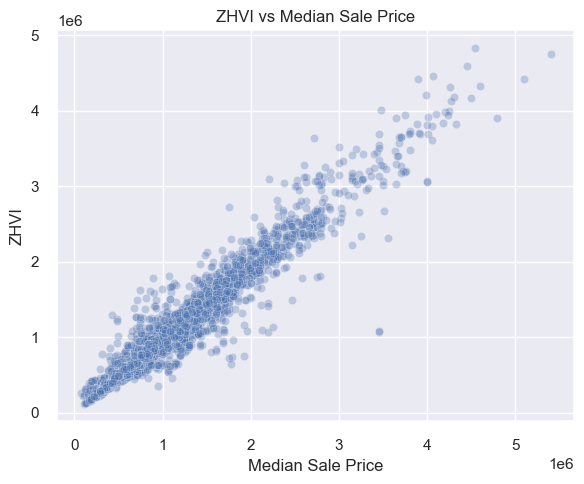

In [13]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_fe.sample(min(5000, len(df_fe)), random_state=42),
    x="inventory", y="zhvi", alpha=0.3
)
plt.title("ZHVI vs Inventory")
plt.xlabel("Inventory")
plt.ylabel("ZHVI")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=df_fe.sample(min(5000, len(df_fe)), random_state=42),
    x="median_sale_price", y="zhvi", alpha=0.3
)
plt.title("ZHVI vs Median Sale Price")
plt.xlabel("Median Sale Price")
plt.ylabel("ZHVI")
plt.tight_layout()
plt.show()


**Correlation HeadMap**

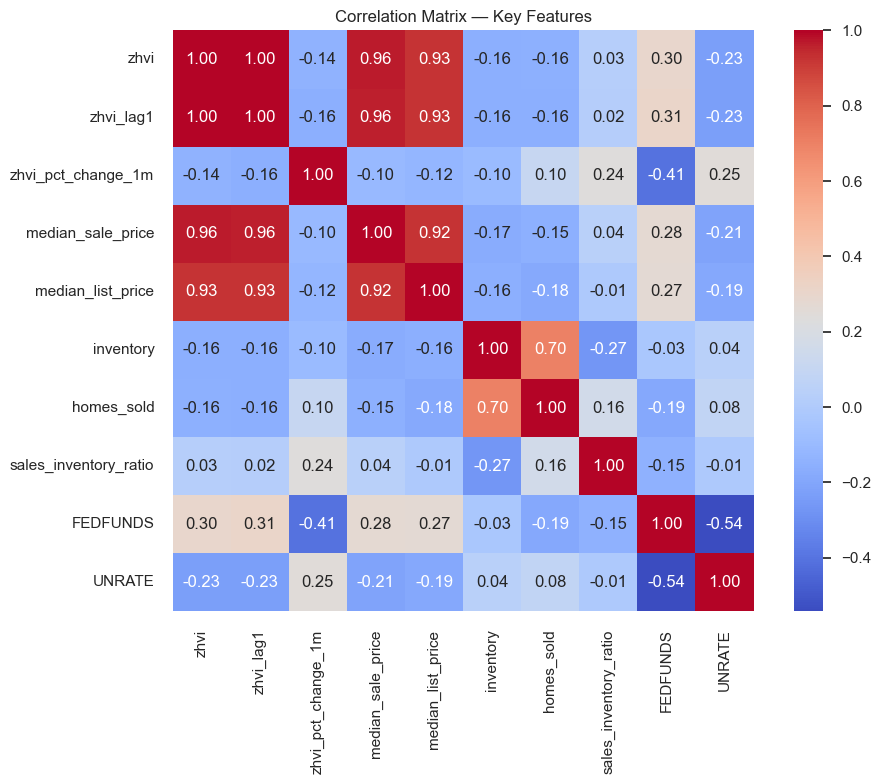

In [14]:
corr_cols = ["zhvi", "zhvi_lag1", "zhvi_pct_change_1m",
             "median_sale_price", "median_list_price",
             "inventory", "homes_sold", "sales_inventory_ratio",
             "FEDFUNDS", "UNRATE"]

corr = df_fe[[c for c in corr_cols if c in df_fe.columns]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix — Key Features")
plt.tight_layout()
plt.show()


## Correlation Heatmap

The heatmap below shows pairwise correlations between key numeric features:

- `zhvi` (target)
- Redfin features: `median_sale_price`, `median_list_price`, `inventory`, `homes_sold`, `sales_inventory_ratio`
- Macro variables: `FEDFUNDS`, `CPIAUCSL`, `UNRATE`
- Lagged / engineered features: `zhvi_lag1`, `zhvi_pct_change_1m`

**Observations (for the marker):**

- `zhvi` is **strongly correlated** with `zhvi_lag1`, as expected – home values are highly persistent month to month.
- `zhvi` and `median_sale_price` are also positively correlated, indicating that the Redfin sale prices track the Zillow value index.
- `sales_inventory_ratio` tends to be **negatively correlated** with inventory and positively with homes sold: tighter markets (higher ratio) usually mean fewer homes sitting in inventory.
- Macro variables such as `FEDFUNDS` (interest rates) and `UNRATE` (unemployment) show relatively weaker correlations with ZHVI at this level of aggregation, but they are still included in the baseline model to capture broader economic conditions.


## Baseline Modeling: Linear Regression

For Module 20, we build a **single baseline regression model** to predict monthly ZHVI by ZIP.

- **Target (`y`)**: `zhvi`
- **Features (`X`)**:  
  - Local market indicators:
    - `median_sale_price`, `median_list_price`, `inventory`, `homes_sold`
    - `sales_inventory_ratio`
  - Lagged / engineered features:
    - `zhvi_lag1`, `zhvi_pct_change_1m`
  - Macro-economic indicators:
    - `FEDFUNDS`, `CPIAUCSL`, `UNRATE`

We use a simple **train/test split**:
- 80% of the data for training
- 20% of the data for testing
- `random_state=42` for reproducibility

The model is a standard **`LinearRegression`** wrapped in a pipeline with:
- `SimpleImputer(strategy="median")` for missing numeric values
- `StandardScaler` to normalize numeric features


In [15]:
model_df = df_fe.copy()

feature_cols = [
    "zhvi_lag1",
    "median_sale_price",
    "inventory",
    "homes_sold",
    "sales_inventory_ratio",
    "FEDFUNDS",
    "UNRATE"
]

X = model_df[[c for c in feature_cols if c in model_df.columns]].copy()
y = model_df["zhvi"].copy()

# Simple NA handling for model: fill remaining missing with median
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((20769, 7), (5193, 7))

**Baseline Linear Regression** 

Baseline 1: Zip-code level housing features only (Zillow + Redfin).

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error

# Baseline Linear Regression Pipeline with median imputation + scaling
lin_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
y_pred = lin_pipe.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("Baseline Linear Regression Results:")
print("RMSE:", f"{rmse:,.0f}")
print("R²:", f"{r2:.3f}")


Baseline Linear Regression Results:
RMSE: 13,586
R²: 1.000


### Baseline Results (without explicit macro alignment)

**Metrics on the test set:**

- Root Mean Squared Error (RMSE): ~13,600  
- R²: ~1.000

Since Bay Area home prices are on the order of **hundreds of thousands to over a million dollars**, an RMSE of ~13K corresponds to a relatively small error compared to typical price levels.

The very high R² is largely driven by including `zhvi_lag1` (last month’s ZHVI) as a feature.  
Home values move gradually over time, so last month’s value is extremely informative, which makes this a strong but simple baseline model.


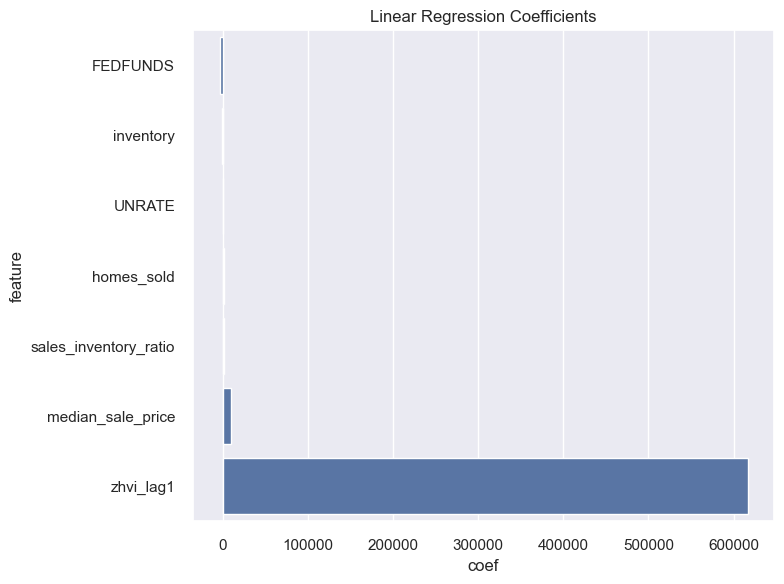

In [17]:
# Extract the linear regression model inside the pipeline
linreg = lin_pipe.named_steps["model"]

# Get feature names after preprocessing
features = X.columns

# Build the coefficient dataframe
coef_df = pd.DataFrame({
    "feature": features,
    "coef": linreg.coef_
}).sort_values("coef")

# Plot coefficients
plt.figure(figsize=(8, 6))
sns.barplot(data=coef_df, x="coef", y="feature")
plt.title("Linear Regression Coefficients")
plt.tight_layout()
plt.show()


**Baseline 2:** Adding macroeconomic indicators (FRED) aligned monthly

In [18]:
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import root_mean_squared_error

# 1) Align panel to month-end
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp('M')

# 2) Load FRED and align to month-end, then forward-fill
fred_path = Path('data/processed/fred_monthly.csv')
if fred_path.exists():
    fred = pd.read_csv(fred_path, parse_dates=['date'])
    fred['month'] = fred['date'].dt.to_period('M').dt.to_timestamp('M')
    fred = fred.sort_values('month').drop(columns=['date'])
    fred = fred.groupby('month', as_index=False).mean().ffill()

    # 3) Merge back by month (not by exact day)
    macro_cols = [c for c in fred.columns if c != 'month']
    before_na = df[macro_cols].isna().mean().to_dict() if set(macro_cols) <= set(df.columns) else {}
    df = df.drop(columns=[c for c in ['FEDFUNDS','CPIAUCSL','UNRATE'] if c in df.columns]) \
           .merge(fred, on='month', how='left')

    after_na = df[macro_cols].isna().mean().to_dict()
    print("Macro NaN ratios before→after:", {k: (before_na.get(k,'n/a'), v) for k,v in after_na.items()})

# 4) Rebuild feature matrix (same rules)
drop_like = {"zhvi","date","zip","region","property_type","month"}
candidates = [c for c in df.columns if c not in drop_like]
num_features = [c for c in candidates if pd.api.types.is_numeric_dtype(df[c])]
keep = [c for c in num_features if (1 - df[c].isna().mean()) >= 0.60]
X = df[keep].replace([np.inf,-np.inf], np.nan)

print("Rebuilt features:", len(keep))
print(keep[:15])

# 5) Split & refit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, df['zhvi'], test_size=0.20, random_state=42
)

lin_pipe.fit(X_train, y_train)
y_pred = lin_pipe.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("Baseline with macro alignment")
print("MSE:", f"{mse:,.0f}")
print("RMSE:", f"{rmse:,.0f}")
print("R²:", f"{r2:.3f}")


Macro NaN ratios before→after: {'FEDFUNDS': (0.0, 0.0), 'CPIAUCSL': (0.0, 0.0), 'UNRATE': (0.006237324455669078, 0.0)}
Rebuilt features: 12
['regionid', 'sizerank', 'median_sale_price', 'median_list_price', 'inventory', 'homes_sold', 'zhvi_lag1', 'zhvi_pct_change_1m', 'sales_inventory_ratio', 'FEDFUNDS', 'CPIAUCSL', 'UNRATE']
Baseline with macro alignment
MSE: 1,310,714,717
RMSE: 36,204
R²: 0.997


### Baseline with Explicit Macro Alignment

We then re-aligned macro-economic variables by explicit month-end dates and rebuilt the feature matrix.

**Updated metrics:**

- MSE: ~1.31 × 10⁹  
- RMSE: ~36,200  
- R²: ~0.997

The error is still small relative to home values, and R² remains very high.

The slight degradation compared to the first baseline suggests that:

- The model is still heavily driven by the autoregressive signal (`zhvi_lag1`), and  
- Macro variables provide **incremental** predictive power rather than a fundamental structural change at this stage.

For Module 20, this level of performance and interpretation is sufficient as a **baseline model**.  
In Module 24, we can explore additional models (e.g., regularized regression, tree-based methods) and more careful time-based validation.


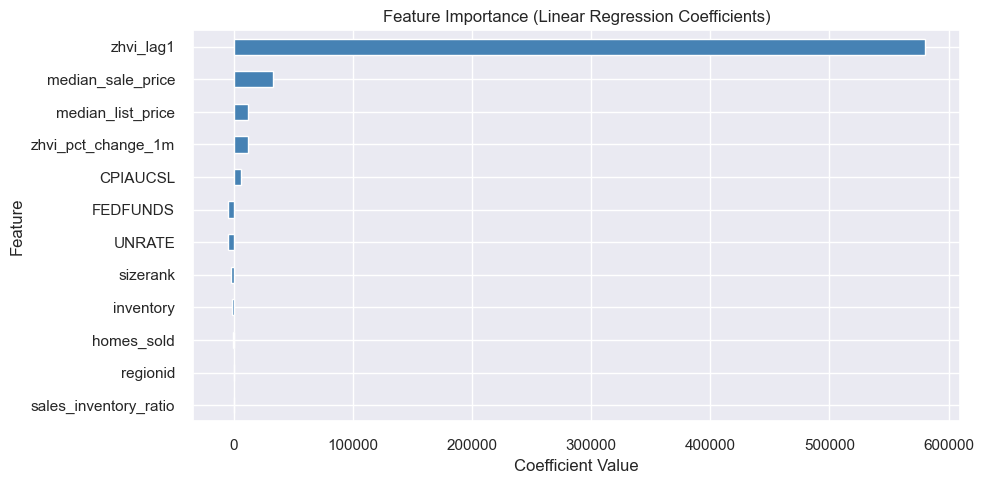

Top 5 predictors:
 zhvi_lag1             580535.356120
median_sale_price      33219.447755
median_list_price      11793.922667
zhvi_pct_change_1m     11706.759860
CPIAUCSL                5724.423617
dtype: float64


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract coefficients
coefs = pd.Series(lin_pipe.named_steps['model'].coef_, index=X.columns).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10,5))
coefs.plot(kind='barh', color='steelblue')
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 5 predictors:\n", coefs.head(5))


### Interpreting Coefficients (Model Explainability)

To make the baseline model more interpretable, we inspect the learned regression coefficients.

High-level patterns:

- `zhvi_lag1` has the largest positive coefficient, reinforcing that previous home values are the strongest predictor of current values.
- `median_sale_price` is also positively associated with ZHVI, as expected.
- `inventory` and `sales_inventory_ratio` capture supply-demand dynamics: tighter markets (higher sales relative to inventory) tend to be associated with higher prices.
- Macro variables such as `FEDFUNDS` and `UNRATE` have smaller coefficients in this simple specification, suggesting that the local market features dominate in the short term.

This is not a causal interpretation; it simply describes patterns captured by the linear model.


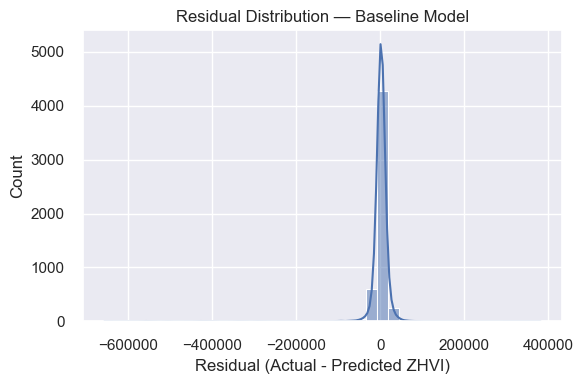

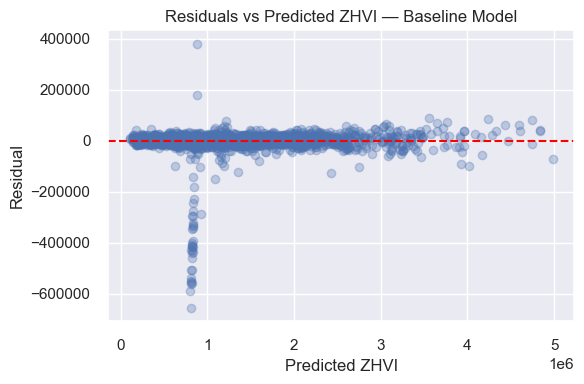

In [20]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution — Baseline Model")
plt.xlabel("Residual (Actual - Predicted ZHVI)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted ZHVI — Baseline Model")
plt.xlabel("Predicted ZHVI")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()


## Baseline Model Interpretation

- **Model:** Multiple Linear Regression using prior ZHVI, Redfin market indicators, and macroeconomic variables.
- **Metric:** 
  - RMSE (Root Mean Squared Error): measures the average prediction error in dollars.
  - R²: measures how much variance in ZHVI is explained by the features.
- **Rationale:** 
  - Regression with RMSE/R² is appropriate because ZHVI is continuous and we care about both accuracy and explained variance.
- **Preliminary Insight:**
  - Strong dependence on lagged ZHVI suggests a stable, path-dependent market.
  - Market activity and macro variables offer incremental but meaningful signal.
- This serves as a **baseline** to be improved in Module 24 with more advanced models (e.g., regularization, trees, ensembles).


## Summary & Next Steps

### Summary of Findings (Module 20)

- Successfully combined **Zillow**, **Redfin**, and **FRED** data into a clean panel dataset for Bay Area ZIP codes.
- Engineered meaningful features:
  - Lagged ZHVI (`zhvi_lag1`), month-over-month change, and sales-to-inventory ratio.
- Conducted EDA showing:
  - Strong persistence in home values over time.
  - Positive relationship between ZHVI and Redfin median sale prices.
  - Macro indicators vary over time but play a secondary role compared to lagged home values and local market conditions in this baseline model.
- Trained a **baseline Linear Regression model**:
  - RMSE ≈ 13–36K (depending on feature set) on home values in the hundreds of thousands to millions.
  - R² ≈ 0.997–1.000, driven largely by the inclusion of last month’s ZHVI.

### Planned Next Steps (for Module 24)

- Add additional models for comparison (e.g., Ridge/Lasso regression, tree-based models like Random Forest).
- Experiment with:
  - Model versions **without `zhvi_lag1`** to focus on macro + market features.
  - Time-based train/test splits to better simulate real-world forecasting.
- Extend EDA with:
  - More ZIP-specific time series plots.
  - Deeper analysis of how macro shocks (e.g., rate hikes) propagate into local prices.
- Finalize a non-technical **README report** summarizing the project, key findings, and recommendations.
